# CS5500 : Reinforcement Learning

# Assignment № 4


# Gantasala Naga Aneesh Ajaroy


# CS19BTECH11010

## Problem 1 : Deep Q Learning

## MountainCar-v0 Environment

### Import Required Libraries

In [1]:
import gym
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from matplotlib.colors import ListedColormap
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# 1a) 

## Printing State and Action Spaces 

In [2]:
def load_env(name):
    env = gym.make(name)
    print("The environment {} is created".format(name))
    
    Observation_Space = env.observation_space
    Action_Space = env.action_space
    
    print("The Observation Space : {}".format(Observation_Space))
    states = Observation_Space.shape
    print("Number of Observations or Dimensions in State : {}".format(states))
    print("The First dimension represents Position")
    print("The Second dimension represents Velocity")
    print("Box represents a continuous ndarray")
    Upper = Observation_Space.high
    Lower = Observation_Space.low
    print("Position is bounded by [{0:8.5f},{1:8.5f}]".format(Lower[0],Upper[0]))
    print("Velocity is bounded by [{0:8.5f},{1:8.5f}]".format(Lower[1],Upper[1]))
    
    print("The Action Space : {}".format(Action_Space))
    actions = Action_Space.n
    print("Number of valid Actions : {}".format(actions))
    print("The discrete Deterministic actions are 0,1,2")
    print("0 -> Accelerate to the left")
    print("1 -> Don't Accelerate")
    print("2 -> Accelerate to the right")
    return env
    

In [3]:
Environment = load_env("MountainCar-v0")

The environment MountainCar-v0 is created
The Observation Space : Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of Observations or Dimensions in State : (2,)
The First dimension represents Position
The Second dimension represents Velocity
Box represents a continuous ndarray
Position is bounded by [-1.20000, 0.60000]
Velocity is bounded by [-0.07000, 0.07000]
The Action Space : Discrete(3)
Number of valid Actions : 3
The discrete Deterministic actions are 0,1,2
0 -> Accelerate to the left
1 -> Don't Accelerate
2 -> Accelerate to the right


## Plotting Rewad Function using Random Agent

In [4]:
def reward_plot(env):
    Reward = []
    position = []
    velocity = []
    Action = []
    for ep in range(1000):
        env.reset()
        while True:
            num_actions = env.action_space.n
            action_space = list(range(num_actions))
            A = random.sample(action_space,1)
            observation, reward, terminated, truncated, info = env.step(A[0])
            
            Action.append(A[0])
            Reward.append(reward)
            position.append(observation[0])
            velocity.append(observation[1])
            
            if terminated or truncated:
                break
                
    plt.subplots(figsize=(35,10))
    
    plt.subplot(1, 4, 1)
    plt.plot(position, Reward, 'r')
    plt.xlabel('position')
    plt.ylabel('reward')

    plt.subplot(1, 4, 2)
    plt.plot(velocity, Reward, 'g')
    plt.xlabel('velocity')
    plt.ylabel('reward')
    
    plt.subplot(1, 4, 3)
    plt.scatter(Action, Reward, c = 'b')
    plt.xlabel('action')
    plt.ylabel('reward')
    
    plt.subplot(1, 4, 4)
    X = np.random.uniform(-1.2,0.6,1000)
    Y = np.random.uniform(-0.07,0.07,1000)
    Z = [(random.randrange(3)) for i in range(len(X))]
    act = ['Acc Left', 'Nothing', 'Acc Right']
    colors = ListedColormap(['r','b','g'])
    plt.xlabel('position')
    plt.ylabel('velocity')
    scatter = plt.scatter(X, Y, c=Z,cmap=colors)
    plt.legend(handles=scatter.legend_elements()[0], labels=act)
    
    
    
    
    plt.show()
        

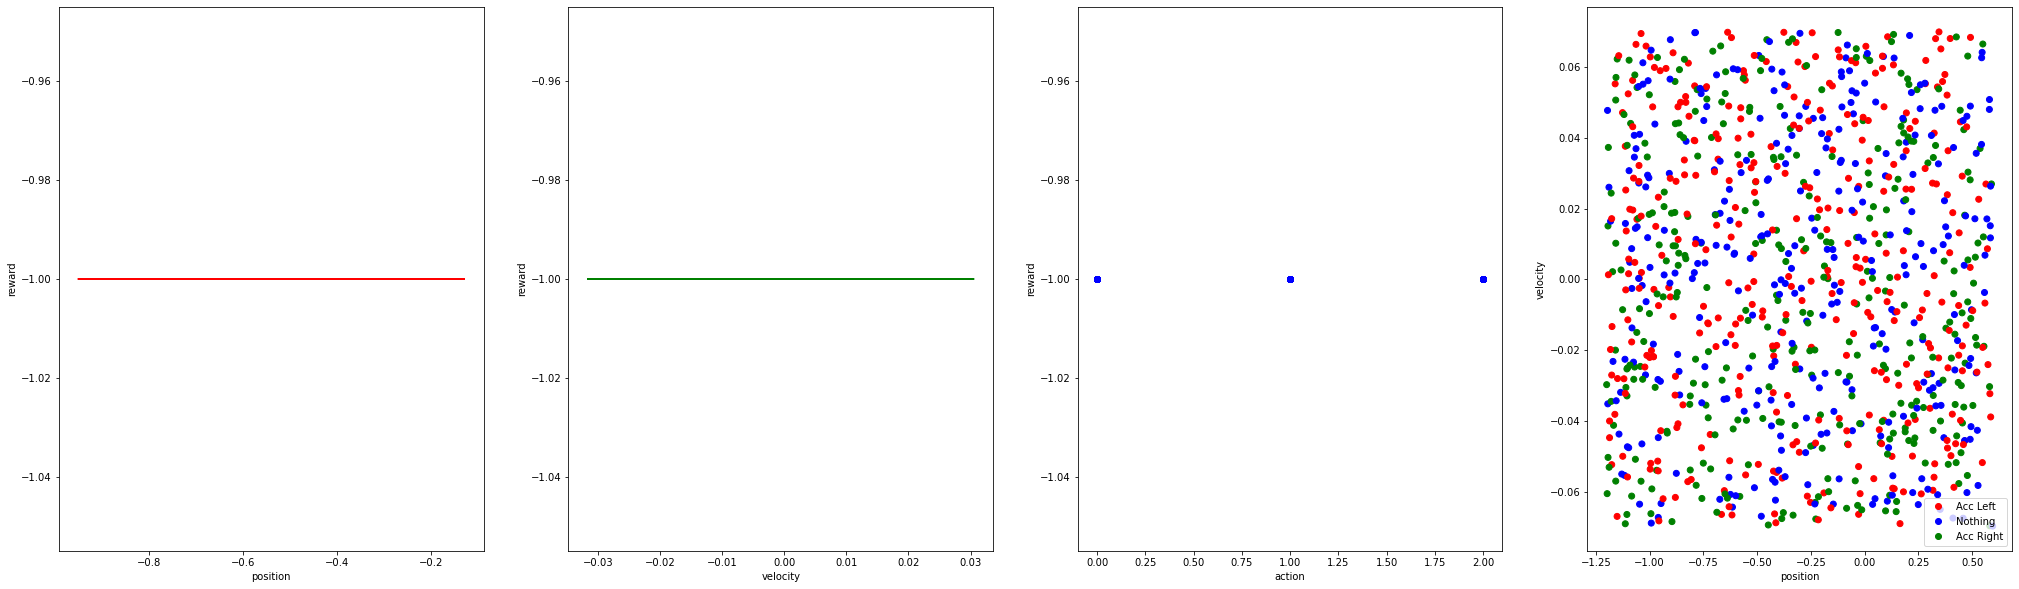

In [5]:
reward_plot(Environment)

# 1b)

## DQN Algorithm

### Deep Q Learning Network

In [6]:

def DQN(input_layer,hidden_layer1,num_actions,lr):
    
    DQNet = Sequential()
    
    DQNet.add(Dense(hidden_layer1, input_dim=input_layer, activation='relu'))
    DQNet.add(Dense(num_actions))
    DQNet.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    return DQNet
    

### Replay Buffer

In [7]:
class ReplayBuffer:
    
    def __init__(self, size, input_shape):
        self.size = size
        self.pos = 0
        self.state = np.zeros((self.size, input_shape), dtype=np.float32)
        self.action = np.zeros(self.size, dtype=np.int32)
        self.reward = np.zeros(self.size, dtype=np.float32)
        self.new_state = np.zeros((self.size, input_shape), dtype=np.float32)
        self.terminal = np.zeros(self.size, dtype=np.bool_)

    def store_tuples(self, S, A, R, NS, done):
        
        i = self.pos % self.size
        self.state[i] = S
        self.action[i] = A
        self.reward[i] = R
        self.new_state[i] = NS
        self.terminal[i] = done
        self.pos += 1

    def sample_buffer(self, batch_size):
        
        max_buffer = min(self.pos, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state[batch]
        action_batch = self.action[batch]
        reward_batch = self.reward[batch]
        new_state_batch = self.new_state[batch]
        done_batch = self.terminal[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

### Agent Class for Creating, Training and  Optimizing our RL Agent

In [8]:
class Agent:
    
    def __init__(self, lr, discount_factor, num_actions, epsilon, batch_size, input_layer,hidden_layer):
        
        self.action_space = [i for i in range(num_actions)]
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.decay = 0.001
        self.max_epsilon = 0.01
        self.update_rate = 100
        self.step_counter = 0
        self.buffer = ReplayBuffer(1000, input_layer)
        self.DQNET = DQN(input_layer,hidden_layer,num_actions,lr)
        self.DQNET_Tar = DQN(input_layer,hidden_layer,num_actions,lr)
        self.Fin_Net = DQN(input_layer,hidden_layer,num_actions,lr)

    def store_tuple(self, state, action, reward, new_state, done):
        self.buffer.store_tuples(state, action, reward, new_state, done)

    def policy(self, observation):
        
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation])
            actions = self.DQNET(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        return action

    def optimize(self):
        
        if self.buffer.pos < self.batch_size:
            return
        
        if self.step_counter % self.update_rate == 0:
            self.DQNET_Tar.set_weights(self.DQNET.get_weights())

        state_batch, action_batch, reward_batch, new_state_batch, done_batch = self.buffer.sample_buffer(self.batch_size)

        Q_pred = self.DQNET(state_batch)
        Q_nxt = self.DQNET_Tar(new_state_batch)
        Q_nxt_max = tf.math.reduce_max(Q_nxt, axis=1, keepdims=True).numpy()
        Q_Req = np.copy(Q_pred)

        
        for i in range(done_batch.shape[0]):
            temp = reward_batch[i]
            if not done_batch[i]:
                temp += self.discount_factor*Q_nxt_max[i]
            Q_Req[i, action_batch[i]] = temp
        self.DQNET.train_on_batch(state_batch, Q_Req)
        
        
        if self.epsilon > self.max_epsilon:
            self.epsilon = self.epsilon - self.decay 
        else:
            self.epsilon = self.max_epsilon
        
        self.step_counter += 1

    def train_model(self, env, num_episodes, mean_n):
        
        
        Eps_Reward = []
        N_Mean_Reward = []
        Best_Mean_Reward = []
        best_reward = -200.0
        success = 0
        Total_steps = []
        s = 0
        
        for i in range(num_episodes):
            terminated,truncated = False,False
            ep_reward = 0.0
            state = env.reset()
            state = state[0]
            while (not terminated) and (not truncated):
                s += 1
                action = self.policy(state)
                observation, reward, terminated, truncated, info = env.step(action)
                ep_reward += reward
                self.store_tuple(state, action, reward, observation, terminated)
                state = observation
                self.optimize()
                if terminated:
                    success += 1
            
            Eps_Reward.append(ep_reward)
            if i >= mean_n:
                present_mean = np.mean(Eps_Reward[-mean_n:])
                N_Mean_Reward.append(present_mean)
                best_reward = max(present_mean,best_reward)
                if best_reward == present_mean:
                    self.Fin_Net.set_weights(self.DQNET.get_weights())
                Best_Mean_Reward.append(best_reward)
                Total_steps.append(s)
            
        
        plt.subplots(figsize=(15,5))
        plt.subplot(1, 2, 1)
        plt.plot(Total_steps, N_Mean_Reward,label=str(mean_n)+"-mean Reward")
        plt.plot(Total_steps,Best_Mean_Reward,label="Best Mean Reward")
        plt.xlabel("Number of steps")
        plt.ylabel('reward')
        plt.title("Performance of Agent")
        plt.legend()
    
        plt.subplot(1, 2, 2)
        X = np.random.uniform(-1.2,0.6,1000)
        Y = np.random.uniform(-0.07,0.07,1000)
        Z = []
        self.DQNET.set_weights(self.Fin_Net.get_weights())
        for i in range(len(X)):
            temp = np.array([X[i],Y[i]])
            temp = self.policy(temp)
            Z.append(temp)
        act = ['Acc Left', 'Nothing', 'Acc Right']
        colors = ListedColormap(['r','b','g'])
        plt.xlabel('positionon')
        plt.ylabel('velocity')
        plt.title("Action Choices")
        scatter = plt.scatter(X, Y, c=Z,cmap=colors)
        plt.legend(handles=scatter.legend_elements()[0], labels=act)
        plt.show()
    
        return N_Mean_Reward,Best_Mean_Reward


### Model hyperparameters

### 1 Hidden Layer of size 256

### Replay Buffer Size = 1000

### lr = 0.001, discount_factor = 0.99, num_actions = 3, epsilon = 1.0, batch_size = 64, input_layer = 2

### num_episodes = 1000, mean_n = 5



## Plots of Learning Curve and Action Choices

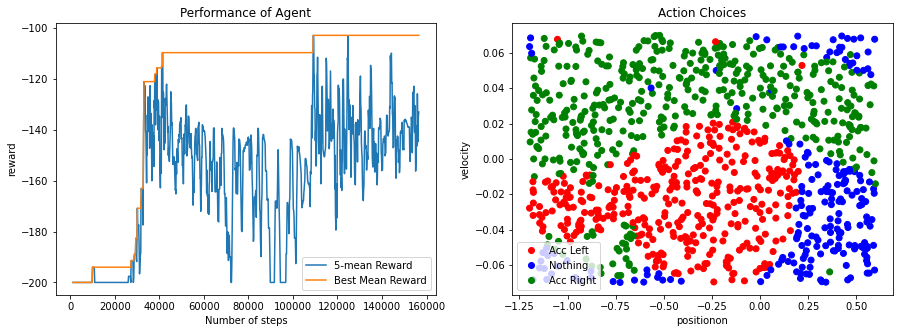

In [9]:
env = gym.make("MountainCar-v0")
num_episodes = 1000
mean_n = 5
Train_Agent = Agent(lr=0.001, discount_factor=0.99, num_actions=3, epsilon=1.0, batch_size=64, input_layer=2,hidden_layer=256)

x,y = Train_Agent.train_model(env, num_episodes, mean_n)

# 1c)

## Alternate Model 1

### Model hyperparameters

### 1 Hidden Layes of size 256

### Replay Buffer Size = 1000

### lr = 0.001, discount_factor = 0.99, num_actions = 3, epsilon = 1.0, batch_size = 16,  input_layer = 2

### num_episodes = 1000, mean_n = 5


### ****Note :- Here batch SIze is decreased from 64 to 16

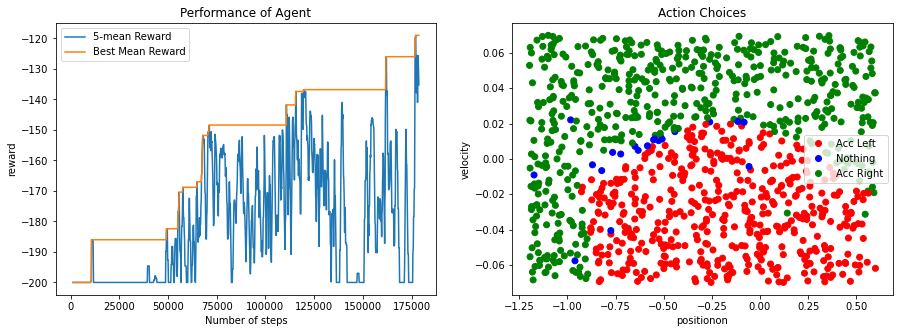

In [10]:
env = gym.make("MountainCar-v0")
num_episodes = 1000
mean_n = 5
Train_Agent = Agent(lr=0.001, discount_factor=0.99, num_actions=3, epsilon=1.0, batch_size=16, input_layer=2,hidden_layer=256)

x1,y1 = Train_Agent.train_model(env, num_episodes, mean_n)

## As can be seen from above plots, by decreasing the Batch Size, 

## Training becomes significantly slower and does'nt converge to optimal with worse Best Reward Mean of -120 compared to -100 of original Model

## Alternate Model 2

### Model hyperparameters

### 1 Hidden Layes of size 256

### Replay Buffer Size = 1000

### lr = 0.0001, discount_factor = 0.99, num_actions = 3, epsilon = 1.0, batch_size = 64, input_layer = 2

### num_episodes = 1000, mean_n = 5

### ****Note :- Here Learning Rate is Decreased from 0.01 to 0.001


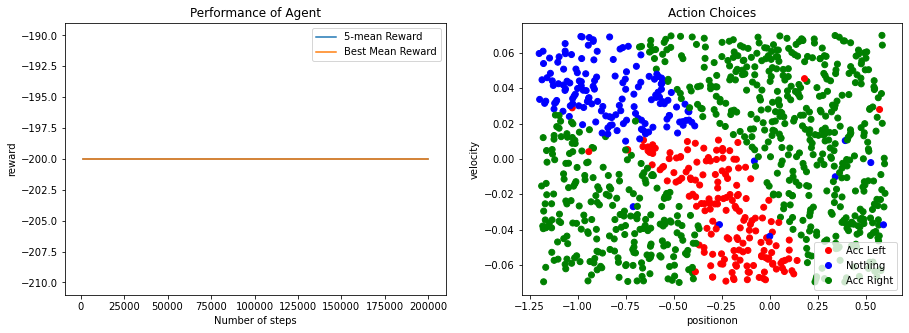

In [11]:
env = gym.make("MountainCar-v0")
num_episodes = 1000
mean_n = 5
Train_Agent = Agent(lr=0.0001, discount_factor=0.99, num_actions=3, epsilon=1.0, batch_size=64, input_layer=2,hidden_layer=256)

x2,y2 = Train_Agent.train_model(env, num_episodes, mean_n)

## As can be seen from above plots, by decreasing the learning Rate , Model is not learning even in 1000 episodes and is a very bad hyperparameter

## Alternate Model 3

### Model hyperparameters

### 1 Hidden Layes of size 512

### Replay Buffer Size = 1000

### lr = 0.0001, discount_factor = 0.99, num_actions = 3, epsilon = 1.0, batch_size = 64, input_layer = 2

### num_episodes = 1000, mean_n = 5

### ****Note :- Here Network Architecture is changed => Hidden Layer size increased from 256 to 512

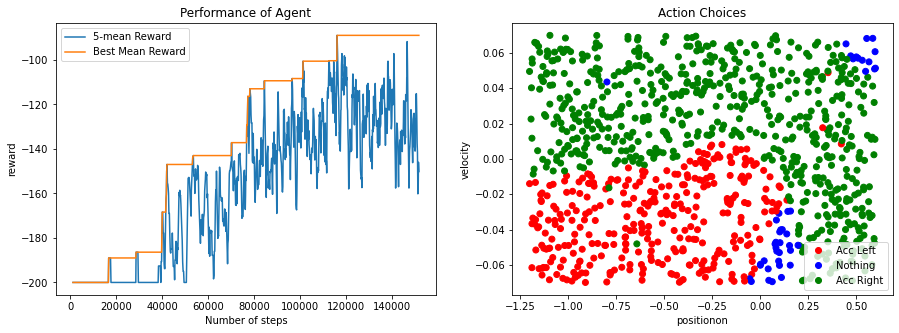

In [12]:
env = gym.make("MountainCar-v0")
num_episodes = 1000
mean_n = 5
Train_Agent = Agent(lr=0.001, discount_factor=0.99, num_actions=3, epsilon=1.0, batch_size=64, input_layer=2,hidden_layer=512)

x3,y3 = Train_Agent.train_model(env, num_episodes, mean_n)

## This model with Architceture of 1 hidden layer of size 512 performs better than our original model with converging to best mean of -80 compared to -100 in original model

## Plotting All 4 Models Learning Curves

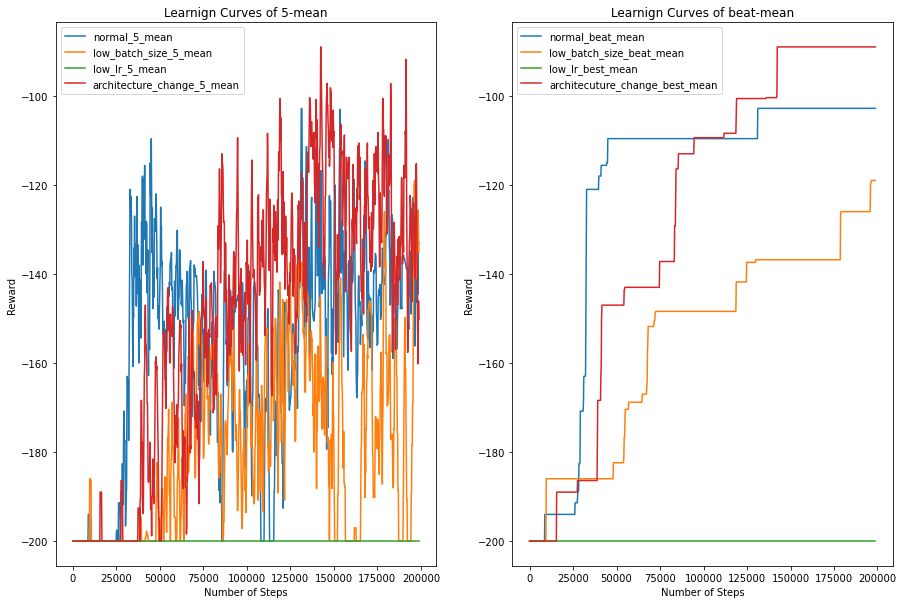

In [13]:
X_len = min(len(x),len(x1),len(x2),len(x3))



plt.subplots(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.xlabel("Number of Steps")
plt.ylabel("Reward")
plt.title("Learnign Curves of 5-mean")
X = np.arange(0, X_len*200,200)
plt.plot(X, x, label = "normal_5_mean")
plt.plot(X, x1, label = "low_batch_size_5_mean")
plt.plot(X, x2, label = "low_lr_5_mean")
plt.plot(X, x3, label = "architecture_change_5_mean")
plt.legend()

X_len = min(len(y),len(y1),len(y2),len(y3))
plt.subplot(1, 2, 2)
X = np.arange(0, X_len*200,200)
plt.xlabel("Number of Steps")
plt.ylabel("Reward")
plt.title("Learnign Curves of beat-mean")
plt.plot(X, y, label = "normal_beat_mean")
plt.plot(X, y1, label = "low_batch_size_beat_mean")
plt.plot(X, y2, label = "low_lr_best_mean")
plt.plot(X, y3, label = "architecuture_change_best_mean")
plt.legend()
plt.show()

# As You can see , Architceture with 1 hidden layer of size 512 performs best

# and the model with lowest Learning Rate (0.0001) doesn't learn